Consideramos el modelo:

$$\mu = 25 - 5 \log_{10}(H_0/100) + 5\log_{10}(D_L/Mpc)$$

Donde $D_L$ tiene como solución aproximada:

$$D_L = {c \over H_0} (1 + z)[\eta(1, \Omega_m) - \eta(1/(1+z), \Omega_m)]$$

Siendo:

$$\eta(a,\Omega_m) = 2\sqrt{s^2+1}[a^{-4} - 0.1540sa^{-3} + 0.4304s^2a^{-2} + 0.19097s^3a^{-1} + 0.066941s^4]^{-1/8}$$

Que a su vez:

$$s^3 = (1- \Omega_m)/\Omega_m$$

Podemos hacer una estimación de los parámetros $H_0$ y $\Omega_m$ que mejor ajustan los datos de nuestro modelo utilizando la función Likelihood:

$$\mathcal{L} \propto \prod_i^n {1 \over 2\pi \sigma_i^2}exp \left( - \frac{(x_i-\mu)^2}{2\sigma_i^2}\right )$$

o bien:

$$-ln(\mathcal{L}) \propto {1 \over 2} \sum_i^n \left( \frac{(y_i - \lambda(x_i, \vec{\theta}))^2}{\sigma_i^2} \right)$$

En este caso, $y_i$ son los datos de $\mu$; $x_i$, los datos para $z$; y los parámetros $\vec{\theta}$ son $\Omega_m$ y $H_0$

Trataremos de maximizar esta función utilizando el algoritmo de Metrópolis

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import math
from random import random, gauss

Text(0.5,1,'Datos a ajustar')

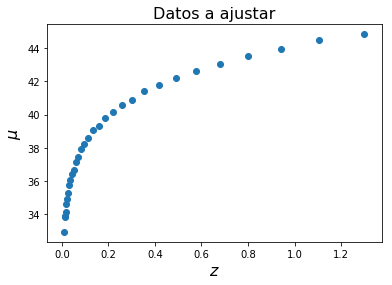

In [5]:
datos = np.loadtxt('JLA_SN/jla_mub.txt', usecols = (0,1), skiprows = 1)
z = datos[:, 0]
mu = datos[:, 1]

plt.scatter(z, mu)
plt.xlabel('$z$', fontsize = 16)
plt.ylabel('$\mu$', fontsize = 16)
plt.title('Datos a ajustar', fontsize = 16)

Como los elementos de la matriz de covarianza están en una lista y solamente nos interesa la varianza, e decir la diagonal de esa matriz, necesitamos saber qué elementos de esa lista son. 

Para una matriz cuadrada de dimensión $n$, los elementos de la diagonal son $i(n+1)$, siendo $i$ el $i$-ésimo elemento de la diagonal.

In [3]:
datos_cov = np.loadtxt('JLA_SN/jla_mub_covmatrix.dat', skiprows = 1)
varianza = np.array([])
for i in range(31):
    varianza = np.append(varianza, datos_cov[i*(31+1)])
    
def s(omega_m):
    return ((1 - omega_m)/omega_m)**(1.0/3.0)

def eta(a, omega_m):
    S = s(omega_m)
    return 2*math.sqrt(S**2 + 1)*(1/(a**4) - 0.1540*S/(a**3) + 0.4304*S**2/(a**2) + 0.19097*S**3/a + 0.066941*S**4)**(-1.0/8.0)

def DL(z,H0,omega_m):
    c = 3.0*10**5
    return c/H0*(1 + z)*(eta(1,omega_m)-eta(1/(1+z), omega_m))

def Mu(z, H0, omega_m):
    return 25 - 5*math.log10(H0/100) + 5*math.log10(DL(z, H0, omega_m))

def ln_L(mu, z, H0, omega_m, varianza):
    suma = 0
    for i in range(len(mu)):
        suma += (mu[i] - Mu(z[i], H0, omega_m))**2/varianza[i]
    return 0.5*suma


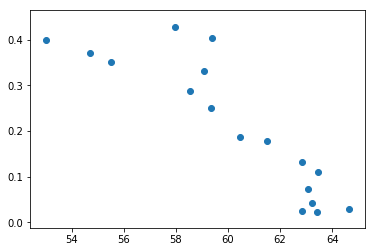

In [46]:
old_H0 = 53
old_Om = 0.4

old_L = ln_L(mu,z,old_H0,old_Om,varianza)

H0_list =[old_H0]
Om_list = [old_Om]
#print(old_L)

for i in range(300):
    new_H0 = gauss(old_H0, 1)
    new_Om = gauss(old_Om, 0.04)
    
    if new_Om < 0 or new_Om > 1:
        new_Om = old_Om
        continue
    elif new_H0 < 50 or new_Om > 100:
        new_H0 = old_Om
        continue
        
    new_L = ln_L(mu,z,new_H0,new_Om, varianza)
    
    if new_L < old_L:
        old_L = new_L
        old_Om = new_Om
        old_H0 = new_H0
        H0_list.append(new_H0)
        Om_list.append(new_Om)
        
    elif math.exp(-new_L) > random():
        print(math.exp(-new_L), -1e3 * math.log(random()))
        old_L = new_L
        old_Om = new_Om
        old_H0 = new_H0
        H0_list.append(new_H0)
        Om_list.append(new_Om)

plt.scatter(H0_list,Om_list)